In [8]:
import math
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import os
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import confusion_matrix
import keras.utils as image
from IPython.utils import io

import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import time
import importlib
import pathlib

import requests
from functools import partial

size_ = (10,8)



In [26]:
train_ds = image.image_dataset_from_directory(
    '/home/sarp/DS5460/garbage_classifier/train/',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=(512,384),
    batch_size=32,
)

test_ds = image.image_dataset_from_directory(
    '/home/sarp/DS5460/garbage_classifier/test/',
    seed=123,
    image_size=(512,384),
    batch_size=32,
)

Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 518 files belonging to 6 classes.


In [30]:
next(iter(test_ds))

(<tf.Tensor: shape=(32, 512, 384, 3), dtype=float32, numpy=
 array([[[[226.     , 229.     , 238.     ],
          [226.     , 229.     , 238.     ],
          [226.83333, 229.83333, 238.83333],
          ...,
          [183.     , 182.     , 187.     ],
          [182.5    , 181.5    , 186.5    ],
          [182.     , 181.     , 186.     ]],
 
         [[226.     , 229.     , 238.     ],
          [226.     , 229.     , 238.     ],
          [226.3125 , 229.3125 , 238.3125 ],
          ...,
          [183.     , 182.     , 187.     ],
          [182.5    , 181.5    , 186.5    ],
          [182.     , 181.     , 186.     ]],
 
         [[225.6875 , 228.6875 , 237.6875 ],
          [226.     , 229.     , 238.     ],
          [226.     , 229.     , 238.     ],
          ...,
          [183.     , 182.     , 187.     ],
          [182.5    , 181.5    , 186.5    ],
          [182.     , 181.     , 186.     ]],
 
         ...,
 
         [[220.     , 222.     , 234.     ],
          [220.

In [12]:
train_ds.class_names

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

In [2]:
class OverfittingCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if logs.get('accuracy') > 0.999:
      self.model.stop_training = True
      print('Trying to prevent overfitting - stopping training')

In [43]:
# Just placing everything in a class to make analysis easier
class TrashClassifer():
    
    def __init__(self, home_path='/home/sarp/DS5460', main_dir='garbage_classifier', model_name='vgg16', crop=False):
        # Define some constants
        self.HOME = Path(home_path)
        self.MAIN_DIR = self.HOME / main_dir #the main directory of this project to include all the data
        
        # Data augmentation switch
        self.crop = crop
        
        crop_string = 'crop' if self.crop else 'no_crop'
        


        self.TEST_PATH = self.MAIN_DIR / 'test'
        self.TRAIN_PATH = self.MAIN_DIR / 'train'

        #TensorBoard - log model statistics
        self.LOGDIR = self.MAIN_DIR / 'my_logs'
        
        self.MODEL_DIR = self.MAIN_DIR / 'models'
        
        self.BASE_URL = 'https://raw.githubusercontent.com/hoganj15/Waste_Image_Classifier/main/images_multiclass'
        
        self.set_up()
        
        # some tricks to load models by name
        from inspect import getmembers, isfunction
        self.available_models = {o[0].lower():o[1]for o in getmembers(keras.applications) if isfunction(o[1])}
        
        model_module = importlib.import_module('keras.applications' + '.' + model_name)
        self.preprocess(model_module.preprocess_input)
        self.model_path = self.MODEL_DIR / (model_name + '_' + crop_string)
        if self.model_path.exists():
            print('Model exists, not training.')
            self.model = tf.keras.models.load_model(self.model_path)
        
        else:
            model_instantiator = self.available_models[model_name.replace('_','')]
            self.train(model_instantiator, weights="imagenet", include_top=False, input_shape=(224, 224, 3))
        
        self.test_model()
    
    def get_run_logdir(self):
        run_id = time.strftime('run_%Y_%m_%d-%H_%M_%S')
        return self.LOGDIR / run_id

    
    def set_up(self):
        if not self.TEST_PATH.exists():
            self.TEST_PATH.mkdir(parents=True)
        if not self.TRAIN_PATH.exists():
              self.TRAIN_PATH.mkdir(parents=True)
        #reading in the files required for image imports

        test_csv_path = self.TEST_PATH / 'test_files.csv'       
        if not test_csv_path.exists():
            r = requests.get(self.BASE_URL + '/' + test_csv_path.name)
            test_csv_path.write_text(r.text)
        
        
        train_csv_path = self.TRAIN_PATH / pathlib.Path('train_files.csv')
        if not train_csv_path.exists():
            r = requests.get(self.BASE_URL + '/' + train_csv_path.name)
            train_csv_path.write_text(r.text)

        file_names = pd.read_csv(test_csv_path)
        for label in file_names.label.unique().tolist():
            label_path = self.TEST_PATH / label
            if not label_path.exists():
                label_path.mkdir() #create a folder for each class in the test directory
            files_to_read = file_names[file_names['label'] == label] #filter the files to read for that folder
            if len(list(label_path.iterdir())) < len(files_to_read): 
                for file_name in files_to_read['file_name'].tolist():
                    url = self.BASE_URL + '/' + 'test' + '/' + label + '/' + file_name
                    r = requests.get(url)
                    file_path = label_path / file_name
                    file_path.write_bytes(r.content)
   
        file_names = pd.read_csv(train_csv_path)
        for label in file_names.label.unique().tolist():
            label_path = self.TRAIN_PATH / label
            if not label_path.exists():
                label_path.mkdir() #create a folder for each class in the train directory
            files_to_read = file_names[file_names['label'] == label] #filter the files to read for that folder
            if len(list(label_path.iterdir())) < len(files_to_read): #only read in images if they aren't already there
                for file_name in files_to_read['file_name'].tolist():
                    url = self.BASE_URL + '/' + 'train' + '/' + label + '/' + file_name
                    r = requests.get(url)
                    file_path = label_path / file_name
                    file_path.write_bytes(r.content)
                    


    def preprocess(self, preprocess_function):
        print(preprocess_function)
        original_size = (512, 384)
        target_size = (224, 224)
        batch_size = 32
        #process = partial(process_img, crop=self.crop)
        
        # resize, rescale, random crop and random flip
        # Set preprocessing based on the crop switch above
        
        if self.crop:
            preprocessing = tf.keras.Sequential([
                keras.layers.Resizing(*target_size),
                #keras.layers.Rescaling(1./255),
                keras.layers.RandomFlip("horizontal_and_vertical"),
                keras.layers.RandomCrop(*target_size),
            ])
        
        else:
            preprocessing = tf.keras.Sequential([
                keras.layers.Resizing(*target_size),
                #keras.layers.Rescaling(1./255),
            ])
        
        folder_names = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
        
        train_ds = image.image_dataset_from_directory(
            '/home/sarp/DS5460/garbage_classifier/train/',
            validation_split=0.2,
            subset='training',
            seed=123,
            image_size=original_size,
            batch_size=batch_size,
        )

        val_ds = image.image_dataset_from_directory(
            '/home/sarp/DS5460/garbage_classifier/train/',
            validation_split=0.2,
            subset='validation',
            seed=123,
            image_size=original_size,
            batch_size=batch_size,            
        )

        test_ds = image.image_dataset_from_directory(
            '/home/sarp/DS5460/garbage_classifier/test/',
            seed=123,
            image_size=original_size,
            batch_size=batch_size,
        )
        self.train_ds = train_ds.map(lambda x, y: (preprocess_function(preprocessing(x)), y))
        self.val_ds = test_ds.map(lambda x, y: (preprocess_function(preprocessing(x)), y))
        self.test_ds = test_ds.map(lambda x, y: (preprocess_function(preprocessing(x)), y))
        
    def train(self, transfer_model, **kwargs):
        base_model = transfer_model(**kwargs)
        
        run_logdir = self.get_run_logdir()
        tensorboard_callback = keras.callbacks.TensorBoard(run_logdir, update_freq="epoch")

        #freeze the base model 
        base_model.trainable = False

        #define the type of NN architecture - sequential model specifies a linear stack of layers 
        model = keras.models.Sequential()

        #add the pre-trained model
        model.add(base_model)

        #pool layer to prepare data as input into dense layer 
        model.add(keras.layers.GlobalAveragePooling2D())
        model.add(keras.layers.Dense(256, activation='relu'))
        #batch normalization layer re-centers and re-scales the network - helps accelerate training
        model.add(keras.layers.BatchNormalization())
        #dropout layer - temporarily deactivates 20% of the nodes in the network each epoch to redistribute weights/help network concentrate on "weak" features and prevent overfitting
        model.add(keras.layers.Dropout(0.2))
        #flatten layer to single array for input into dense layer 
        model.add(keras.layers.Flatten())
        # prediction layer - 6 neurons = 6 category outputs, and softmax to normalize the output of the network to a probability distribution over the predicted output classes 
        model.add(keras.layers.Dense(6, activation='softmax'))
        #compile model, specify sparse categorical crossentropy for classification and evaluate accuracy
        model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        #train model for 40 epochs 
        history = model.fit(self.train_ds, epochs=40, validation_data = self.val_ds, callbacks = [keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'), OverfittingCallback(), tensorboard_callback])
        #unfreeze base model 
        base_model.trainable = True
        model.summary()
        history = model.fit(self.train_ds, epochs=40, validation_data=self.val_ds, callbacks=[keras.callbacks.EarlyStopping(patience=1, monitor='val_loss'), OverfittingCallback()])
        model.save(self.model_path)
        self.model = model
        
    def class_convert(self, classess):
        pred=[]
        for i in classess:
            if i ==0:
                pred.append('Cardboard')
            elif i==1:
                pred.append('Glass')
            elif i==2:
                pred.append('Metal')
            elif i==3:
                pred.append('Paper')
            elif i==4:
                pred.append('Plastic')
            elif i==5:
                pred.append('Trash')
        return pred

    def test_model(self):        
        result = self.model.evaluate(self.test_ds)
        dict(zip(self.model.metrics_names, result))
        
        self.model.summary()

    
        y_pred = []
        y_true = []
        for batch_x, batch_y in self.test_ds:
            y_true.append(batch_y)
            
            preds = self.model.predict(batch_x)
            y_pred.append(np.argmax(preds, axis=-1))
            
        correct_labels = tf.concat([item for item in y_true], axis = 0).numpy()
        predicted_labels = tf.concat([item for item in y_pred], axis = 0).numpy()

        
#         correct = (correct_labels == predicted_labels).sum()
#         incorrect = (correct_labels != predicted_labels).sum()
#         print(f"Accuracy {correct/(correct+incorrect)}")

        cm=confusion_matrix(correct_labels, predicted_labels)
        df_cm = pd.DataFrame(cm, range(cm.shape[0]), range(cm.shape[1]))
        df_cm.columns = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']
        df_cm.index = ['Cardboard','Glass','Metal','Paper','Plastic','Trash']

        fig = plt.subplots(figsize=size_)
        sb.set(font_scale=1)
        sb.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="viridis") # font size
        plt.show()



<function preprocess_input at 0x7f76cfdb9670>
Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 2009 files belonging to 6 classes.
Using 401 files for validation.
Found 518 files belonging to 6 classes.
Epoch 1/40
51/51 [==============================] - 456s 9s/step - loss: 0.9719 - accuracy: 0.6604 - val_loss: 0.7122 - val_accuracy: 0.7896
Epoch 2/40
51/51 [==============================] - 433s 8s/step - loss: 0.4027 - accuracy: 0.8595 - val_loss: 0.4444 - val_accuracy: 0.8359
Epoch 3/40
51/51 [==============================] - 428s 8s/step - loss: 0.2724 - accuracy: 0.9055 - val_loss: 0.4411 - val_accuracy: 0.8552
Epoch 4/40
51/51 [==============================] - 420s 8s/step - loss: 0.2210 - accuracy: 0.9347 - val_loss: 0.4033 - val_accuracy: 0.8745
Epoch 5/40
51/51 [==============================] - 472s 9s/step - loss: 0.1401 - accuracy: 0.9652 - val_loss: 0.4297 - val_accuracy: 0.8687
Epoch 6/40
51/51 [==============================] - 418s 8s/step

INFO:tensorflow:Assets written to: /home/sarp/DS5460/garbage_classifier/models/vgg16_crop/assets


INFO:tensorflow:Assets written to: /home/sarp/DS5460/garbage_classifier/models/vgg16_crop/assets


17/17 [==============================] - 102s 6s/step - loss: 0.4255 - accuracy: 0.8707
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 batch_normalization_1 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                               

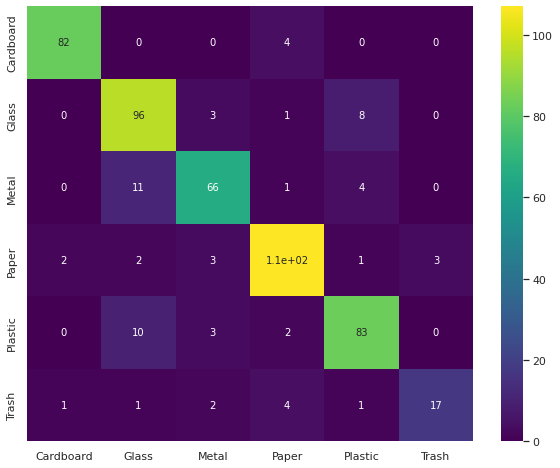

In [45]:
classifier = TrashClassifer(model_name='vgg16', crop=True)


In [46]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

ERROR: Failed to launch TensorBoard (exited with 255).
Contents of stderr:
2022-12-13 21:30:25.448299: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 21:30:25.789313: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 21:30:25.789336: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 21:30:25.836579: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been regi

<function preprocess_input at 0x7f76cfd90d30>
Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 2009 files belonging to 6 classes.
Using 401 files for validation.
Found 518 files belonging to 6 classes.
Model exists, not training.
17/17 [==============================] - 16s 770ms/step - loss: 0.4018 - accuracy: 0.8591
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_2   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_4 (Dense)             (None, 256)               262400    
                                  

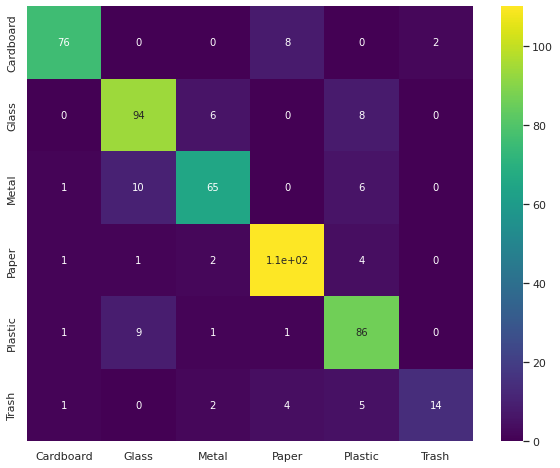

In [49]:
classifier = TrashClassifer(model_name='mobilenet', crop=True)


<function preprocess_input at 0x7f76cfd9e1f0>
Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 2009 files belonging to 6 classes.
Using 401 files for validation.
Found 518 files belonging to 6 classes.
Model exists, not training.
17/17 [==============================] - 12s 593ms/step - loss: 0.4742 - accuracy: 0.8571
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 256)               327936    
                                  

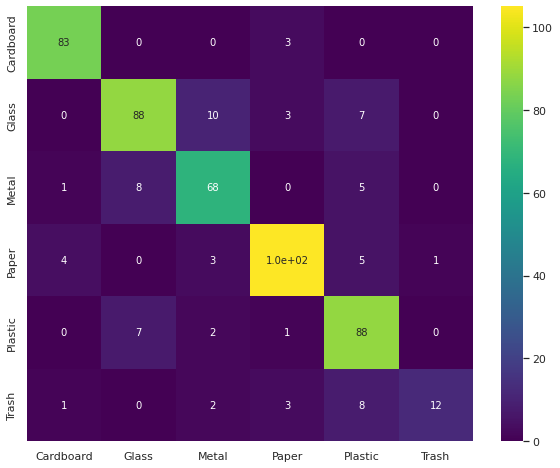

In [50]:
classifier = TrashClassifer(model_name='mobilenet_v2', crop=True)

<function preprocess_input at 0x7f76cfdb9670>
Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 2009 files belonging to 6 classes.
Using 401 files for validation.
Found 518 files belonging to 6 classes.
Model exists, not training.
17/17 [==============================] - 127s 7s/step - loss: 0.3834 - accuracy: 0.8745
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               131328    
                                                                 
 batch_normalization (BatchN  (None,

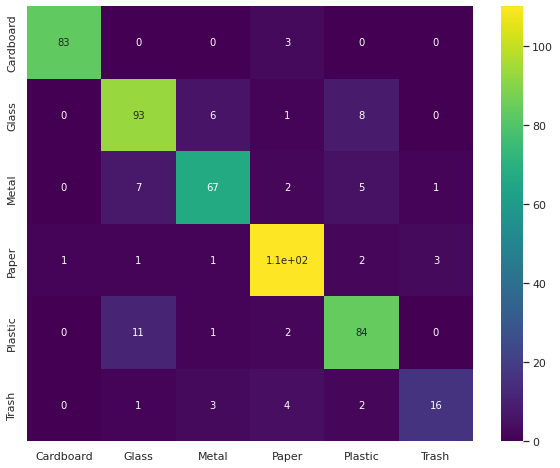

In [51]:
classifier = TrashClassifer(model_name='vgg16', crop=False)

<function preprocess_input at 0x7f76cfd90d30>
Found 2009 files belonging to 6 classes.
Using 1608 files for training.
Found 2009 files belonging to 6 classes.
Using 401 files for validation.
Found 518 files belonging to 6 classes.
Model exists, not training.
17/17 [==============================] - 11s 512ms/step - loss: 0.4383 - accuracy: 0.8610
Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d_1   (None, 1024)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               262400    
                                  

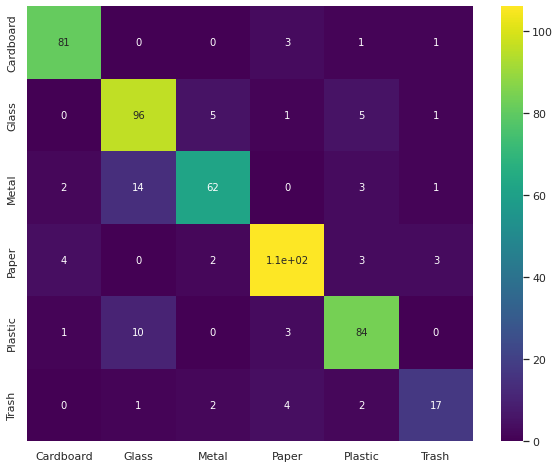

In [52]:
classifier = TrashClassifer(model_name='mobilenet', crop=False)
